In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal

## Parameters & Data Generation

In [2]:
k_max = 7
k = 3
cbar = 1
sd_exp = 0.2
N = 50

y_ref = np.ones(N)
x = np.linspace(0.01, 0.9, N)
higher_orders = np.arange(k+1, k_max)
orders = np.arange(k)
rng = np.random.default_rng(3)
c_true_all = rng.normal(0, cbar, k_max)
c_true_higher = c_true_all[k+1:]
c_true = c_true_all[:k]

X = np.array([y_ref * x ** n for n in orders]).T
y_th = y_ref * np.sum(c_true * x[:, None] ** orders, axis=-1)
dy_th = y_ref * np.sum(c_true_higher * x[:, None] ** higher_orders, axis=-1)
dy_exp = rng.normal(0, sd_exp, N)
y_exp = y_th + dy_th + dy_exp

Text(0.5, 0, 'x')

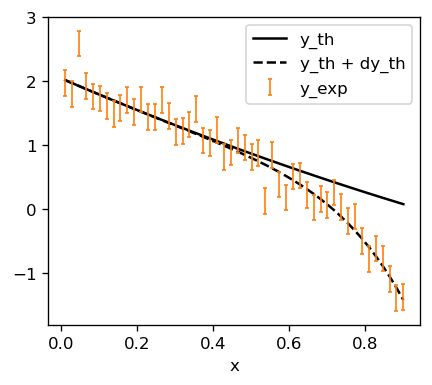

In [20]:
fig, ax = plt.subplots(figsize=(4, 3.4))

plt.plot(x, y_th, label="y_th", c="k")
plt.plot(x, y_th + dy_th, label="y_th + dy_th", c="k", ls='--')
plt.errorbar(x, y_exp, sd_exp, lw=0, elinewidth=1, barsabove=True, capsize=1, label="y_exp", c="C1")
plt.legend()
ax.set_xlabel("x")

## Fit Coefficients

This is a linear model and so we can use the standard linear regression equations to find the posterior distribution
$$
    \vec{a} \,|\, y_{\text{exp}} \sim N[\mu_a, \Sigma_a] \\
    \mu_a = \Sigma_a X^T (\Sigma_\text{th} + \Sigma_\text{exp})^{-1} y_\text{exp} \\
    \Sigma_a = [X^T (\Sigma_\text{th} + \Sigma_\text{exp})^{-1} X]^{-1}
$$

In [4]:
Sigma_th = y_ref[:, None] * y_ref * cbar ** 2 * np.sum([x[:, None]**n * x**n for n in higher_orders], axis=0)
Sigma_exp = sd_exp ** 2 * np.eye(N)

In [5]:
c_var_inv = X.T @ np.linalg.solve(Sigma_th + Sigma_exp, X)
c_var = np.linalg.inv(c_var_inv)
c_est = np.linalg.solve(c_var_inv, X.T @ np.linalg.solve(Sigma_th + Sigma_exp, y_exp))

In [6]:
c_var_inv

array([[736.25675696, 200.7759654 ,  70.72325179],
       [200.7759654 ,  75.4755971 ,  31.01378865],
       [ 70.72325179,  31.01378865,  14.11457692]])

In [7]:
c_var

array([[ 0.00990515, -0.06132342,  0.08511392],
       [-0.06132342,  0.5160944 , -0.82673757],
       [ 0.08511392, -0.82673757,  1.46095282]])

## PPD Calculation

The PPD for the theory prediction can be calculated analytically. If $y_\text{th} = X \vec{a}$, then
$$
  y_\text{th} \,|\, y_\text{exp} \sim N[X\mu_a, X \Sigma_a X^T]
$$

In [8]:
y_th_ppd_mean = y_ref * np.sum(c_est * x[:, None] ** orders, axis=-1)
y_th_ppd_stdv = np.sqrt(np.diag(X @ c_var @ X.T))

But the PPD when including truncation error is slightly trickier, but still analytic. This time, use the conditional GP equations *first*, and then integrate out the coefficients as above.

In [9]:
y_tot_ppd_mean = y_th_ppd_mean + Sigma_th @ np.linalg.solve(Sigma_th + Sigma_exp, y_exp - y_th_ppd_mean)

Z = X - Sigma_th @ np.linalg.solve(Sigma_th + Sigma_exp, X)

y_tot_ppd_cov = Sigma_th - Sigma_th @ np.linalg.solve(Sigma_th + Sigma_exp, Sigma_th) + Z @ c_var @ Z.T
y_tot_ppd_stdv = np.sqrt(np.diag(y_tot_ppd_cov))

## Results

Text(0.5, 0, 'x')

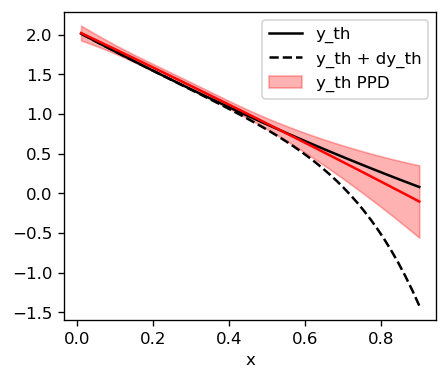

In [21]:
fig, ax = plt.subplots(figsize=(4, 3.4))

ax.plot(x, y_th, label="y_th", c="k")
ax.plot(x, y_th + dy_th, label="y_th + dy_th", c='k', ls='--')
ax.plot(x, y_th_ppd_mean, c="r")
ax.fill_between(x, y_th_ppd_mean+y_th_ppd_stdv, y_th_ppd_mean - y_th_ppd_stdv, label="y_th PPD", color="r", alpha=0.3)
ax.legend()
ax.set_xlabel("x")

Text(0.5, 0, 'x')

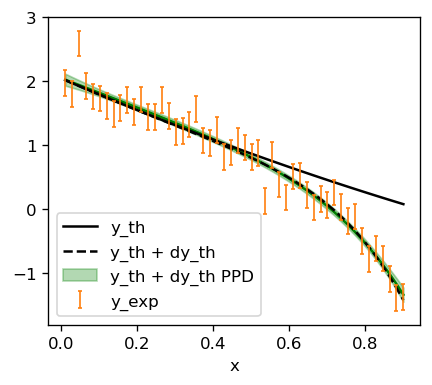

In [22]:
fig, ax = plt.subplots(figsize=(4, 3.4))

ax.plot(x, y_th, label="y_th", c="k")
ax.plot(x, y_th + dy_th, label="y_th + dy_th", c="k", ls='--')
plt.errorbar(x, y_exp, sd_exp, lw=0, elinewidth=1, barsabove=True, capsize=1, label="y_exp", c="C1")
ax.plot(x, y_tot_ppd_mean, c="g", zorder=0)
ax.fill_between(x, y_tot_ppd_mean+y_tot_ppd_stdv, y_tot_ppd_mean - y_tot_ppd_stdv, label="y_th + dy_th PPD", color="g", alpha=0.3, zorder=0)
ax.legend()
ax.set_xlabel("x")

Text(0.5, 0, 'x')

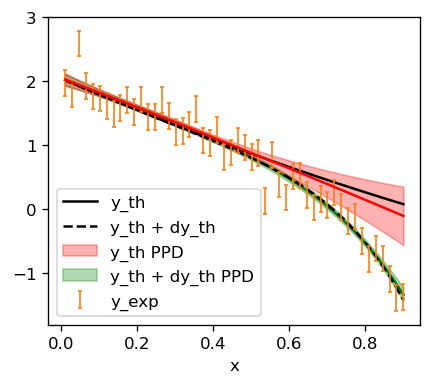

In [15]:
fig, ax = plt.subplots(figsize=(4, 3.4))

ax.plot(x, y_th, label="y_th", c="k")
ax.plot(x, y_th + dy_th, label="y_th + dy_th", c="k", ls='--')
plt.errorbar(x, y_exp, sd_exp, lw=0, elinewidth=1, barsabove=True, capsize=1, label="y_exp", c="C1")
ax.plot(x, y_th_ppd_mean, c="r")
ax.fill_between(x, y_th_ppd_mean+y_th_ppd_stdv, y_th_ppd_mean - y_th_ppd_stdv, label="y_th PPD", color="r", alpha=0.3)
ax.plot(x, y_tot_ppd_mean, c="g", zorder=0)
ax.fill_between(x, y_tot_ppd_mean+y_tot_ppd_stdv, y_tot_ppd_mean - y_tot_ppd_stdv, label="y_th + dy_th PPD", color="g", alpha=0.3, zorder=0)
ax.legend()
ax.set_xlabel("x")

## Non-PPD Calculation


Although not the PPD, it is sometimes useful to look at the distribution of $y_\text{th} + \delta y_\text{th}$ sampled over our posterior values for $\vec{a}$. So rather than conditioning $y_\text{th} + \delta y_\text{th}$ on the experimental values, we instead use its unconditional distribution. This quantity can be described as
$$
    y_\text{th} + \delta y_\text{th} \, | \, I_{\vec{a} \,|\, y_\text{exp}}
$$
where $I_{\vec{a} \,|\, y_\text{exp}}$ is the information about the posterior distribution of $\vec{a}$.

In [16]:
y_th_non_ppd_stdv = np.sqrt(np.diag(Sigma_th)) + np.sqrt(np.diag(X @ c_var @ X.T))

Text(0.5, 0, 'x')

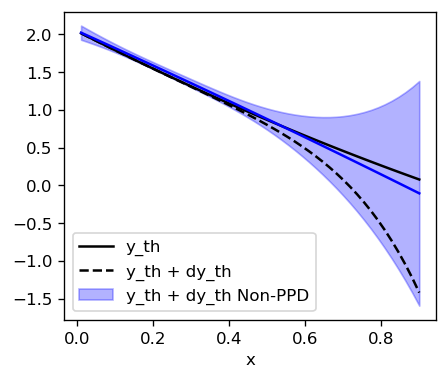

In [19]:
fig, ax = plt.subplots(figsize=(4, 3.4))

ax.plot(x, y_th, label="y_th", c="k")
ax.plot(x, y_th + dy_th, label="y_th + dy_th", c='k', ls='--')
ax.plot(x, y_th_ppd_mean, c="b")
ax.fill_between(x, y_th_ppd_mean + y_th_non_ppd_stdv, y_th_ppd_mean - y_th_non_ppd_stdv, label="y_th + dy_th Non-PPD", color="b", alpha=0.3)
ax.legend()
ax.set_xlabel("x")